## <center> Homework 2 </center>
<center> Tara Wilson </center>
<center> DATA 558 </center>
<center> April 18, 2019 </center>

In [1]:
# imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from scipy.linalg import eigh
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import os
import copy 


### Exercise 1

In this exercise, you will implement in Python a first version of your own fast gradient algorithm to solve the $l_2^2$-regularized logistic regression problem. Recall from the lectures that the logistic regression problem writes as $$min F(\beta) := \frac{1}{n} \sum_{i=1}^{n} \log(1 + \exp(-y_ix_i^T\beta)) + \lambda ||\beta||_2^2$$. We use here the machine learning convention for the labels that is $y_i \in {-1, 1}$.

#### 1.1 Fast Gradient
**The  fast gradient algorithm is outlined in Algorithm 1. The algorithm requires a subroutine
that computes the gradient for any β.**

**Assume that _d = 1_ and _n = 1_. The sample is then of size 1 and boils down to just _(x, y)_. The function *F* writes simply as $$F(\beta) = \log(1+\exp(-yx\beta))+ \lambda\beta^2$$  Compute and write down the gradient $\nabla F$ of F.**

We solve for the gradient by finding the derivative of $F(\beta)$, and I will start by breaking the derivitive into 2 sections:  
$h'(\beta) = \frac{\partial}{\partial \beta} \log(1+\exp(-yx\beta))$  
$g'(\beta) = \frac{\partial}{\partial \beta} \lambda\beta^2$  

We will start with the derivative of h where we will need to apply the chain rule where $g(\beta) = f(h(j(\beta)))$:  
In our case, $f = log(...)$, $h = 1 + exp(-...)$, and $j = yxb$ and we want to solve for $j(x)*h'(j(x))*f'(h(j(x))$.  

Starting with $j(x)$:  
$j'(\beta) = \frac{\partial}{\partial \beta} yx\beta = yx$  

Now for $h'(j(x))$:  
$h'(j(\beta)) = \frac{\partial}{\partial \beta} 1 + exp(-yx\beta) = -exp(-yx\beta)$

For the last term $f'(h(j(x))$ we have:  
$f'(h(j(\beta) = \frac{\partial}{\partial \beta} log(1+\exp(-yx\beta)) = \frac{1}{1+\exp(-yx\beta)}$  

Putting this all back together we have the derivative of the first term:  
$h'(\beta) = (yx)(-exp(-yx\beta))(\frac {1}{1+ \exp (-yx \beta )})$  

Finally, solving for the derivative of g:  
$g'(\beta) = \frac{\partial}{\partial \beta} \lambda\beta^2 = 2\lambda\beta$  

Putting these together we arrive at the gradient of F:  
$\nabla F = \frac{-yxexp(-yx\beta)}{1 + exp(-yx\beta)} + 2\lambda\beta$

**Assume now that _d > 1_ and _n > 1_. Using the previous result and the linearity of differentiation, compute and write down the gradient $\nabla F$ of F.** 

With d > 1 and n > 1,   
$F'(\beta) = \frac{\partial}{\partial \beta} \frac{1}{n} \sum_{i=1}^{n} \log(1 + \exp(-y_ix_i^T\beta)) + \lambda ||\beta||_2^2$  

Since the $frac{1}{n} \sum_{i=1}^{n}$ terms are constants in terms of the derivative we can rearrange:  
$F'(\beta) = \frac{1}{n} \sum_{i=1}^{n} \frac{\partial}{\partial \beta} \log(1 + \exp(-y_ix_i^T\beta)) + \lambda ||\beta||_2^2$  

Again I will start by breaking the derivitive into 2 sections:  
$h'(\beta) = \frac{\partial}{\partial \beta} \log(1 + \exp(-y_ix_i^T\beta))$  
$g'(\beta) = \frac{\partial}{\partial \beta} \lambda ||\beta||_2^2$  

We will start again with the derivative of h where we will need to apply the chain rule where $g(\beta) = f(h(j(\beta)))$: 
In our case, $f = log(...)$, $h = 1 + exp(-...)$, and $j = y_ix_i^T\beta$ and we want to solve for $j(x)*h'(j(x))*f'(h(j(x))$.  

Starting with $j(x)$ and applying the fact that $\frac{\partial}{\partial x} (a^Tx) = a$:  
$j'(\beta) = \frac{\partial}{\partial \beta} y_ix_i^T\beta = y_ix_i$  

Now for $h'(j(x))$:  
$h'(j(\beta)) = \frac{\partial}{\partial \beta} 1 + \exp(-y_ix_i^T\beta) = -exp(-y_ix_i^T\beta)$

For the last term $f'(h(j(x))$ we have:  
$f'(h(j(\beta) = \frac{\partial}{\partial \beta} \log(1 + \exp(-y_ix_i^T\beta)) = \frac{1}{1+\exp(-y_ix_i^T\beta)}$  

Putting this all back together we have the derivative of the first term:  
$h'(\beta) = (y_ix_i)(-exp(-y_ix_i^T\beta)(\frac {1}{1+ \exp (-y_ix_i^T\beta)})$  

Finally, solving for the derivative of g:  
$g'(\beta) = \frac{\partial}{\partial \beta} \lambda ||\beta||_2^2 = 2\lambda\beta$  

Putting these together we arrive at the gradient of F:  
$\nabla F = \frac{-y_ix_iexp(-y_ix_i^T\beta)}{1 + exp(-y_ix_i^T\beta)} + 2\lambda\beta$  

To simplify, we can follow notation that $1-p_i = \frac{exp(-y_ix_i^T\beta)}{1 +e xp(-y_ix_i^T\beta)}$  

Subbing this in we get that $\nabla F = -y_ix_i(1-p_i) + 2\lambda\beta$

We define P as the diagonal of a matrix made of $(1- p_i)$ terms, and therefore can simplify our final solution:  
$\nabla F = -\frac{1}{n} XYP + 2\lambda\beta$  

**Consider the Spam dataset from The Elements of Statistical Learning (You can get it here: https://web.stanford.edu/~hastie/ElemStatLearn/). Standardize the data (i.e., center the features and divide them by their standard deviation, and also change the output labels to +/- 1).**

In [2]:
spam = pd.read_csv("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.data", sep=" ", 
                   na_values="?", header=None)
spam = spam.dropna()
X = spam.iloc[:, 0:57]
y = spam.iloc[:,-1].replace(0,-1)
y = np.array(y).reshape(y.shape[0], 1)

# Divide the data into training and test sets. By default, 25% goes into the test set.
X, X_test, y, y_test = train_test_split(X, y, random_state=0)


# standardizing X by subtracting the mean of the predictors and dividing by their standard deviation
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

**Write a function _computegrad_ that computes and returns $\nabla F(\beta)$ for any $\beta$.**

In [3]:
def computegrad(X, y, beta, lamb = 0.05):
    """
    Computes the gradient for the fast gradient algorithm
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - beta: vector of beta constants
        - lambda: scalar multiplicative factor for regularization penalty (optional, defaults to 0.05)
    Outputs:
        - vector gradient for passed in parameters
    """
    n = len(X) 
    P = np.zeros((X.shape[0], X.shape[0]))
    for i in range(0, X.shape[0]):
        xi = X[i,:]
        #yi = y[i][0]
        yi = y[i]
        p = ((np.exp(-yi * (xi).dot(beta))) / (1 + (np.exp(-yi * (xi).dot(beta)))))
        P[i,i] = p  
    return ((-1/n) * X.T.dot(P).dot(y) + 2*lamb*beta)

In [4]:
def computeobj(X, y, beta, lamb = 0.05):
    """
    Computes the objective for ridge regression problem
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - beta: vector of beta constants
        - lambda: scalar multiplicative factor for regularization penalty (optional, defaults to 0.05)
    Outputs:
        - objective for passed in parameters
    """
    n = len(X)
    summation = 0
    for i in range(0, X.shape[0]):
        xi = X[i,:]
        #yi = y[i][0]
        yi = y[i]
        x = -yi*xi.dot(beta)
        if(x > 0):
            a = x + 1
            logTerm = a + np.log(np.exp(-a) + np.exp(x-a))
        else:
            logTerm = np.log(1 + np.exp(x))
        summation = summation + logTerm
    
    return ((1/n) * summation + (lamb * np.sum(beta**2)))[0]

**Write a function _backtracking_ that implements the backtracking rule.**

In [5]:
def backtracking(X, y, beta, eta, alpha = 0.5, gamma=0.8):
    """
    Implements backtracking rule
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - beta: vector of beta constants
        - eta: initial step size
        - alpha: constant used to define sufficinet decrease condition
        - gamma: constant to scale step size by until condition met         
    Outputs:
        - step size
    """
    grad = computegrad(X, y, beta)  # Gradient at beta
    conditionMet = False
    while not conditionMet:    
        if computeobj(X, y, beta - eta*grad)< computeobj(X, y, beta) - alpha*eta*np.linalg.norm(grad)**2:
            conditionMet = True
        else:
            eta = eta * gamma            
    return eta

**Write a function _graddescent_ that implements the gradient descent algorithm with the backtracking rule to tune the step-size. The function _graddescent_ calls _computegrad_ and _backtracking_ as subroutines. The function takes as input the initial point, the initial step-size value, and the target accuracy ε. The stopping criterion is $||\nabla F|| \leq \epsilon$**

In [6]:
def graddescent(X, y, stepSize, targetAccuracy = 0.001, lamb = 0.05):
    """
    Implements gradient descent algorithm with backtracking
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - stepSize: initial step size
        - targetAccuracy: target accuracy value for algorithm
        - lambda: scalar multiplicative factor for regularization penalty (optional, defaults to 0.05)
    Outputs:
        - betas: vector of improved betas after final iteration
        - objs: vector of objective values for each iteration
    """
    x = X
    beta = np.zeros((X.shape[1], 1))
    objs = [computeobj(x, y, beta, lamb)]
    betas = [beta]
    grad = computegrad(x, y, beta, lamb)
    t = 0
    while (np.linalg.norm(grad) > targetAccuracy):
        stepSize = backtracking(x, y, beta, stepSize)
        beta = beta - stepSize * grad
        betas.append(beta) # saves current beta values
        obj = computeobj(x, y, beta, lamb)
        objs.append(obj) # saves current objective value
        grad = computegrad(x, y, beta, lamb)
        t = t + 1
    return np.array(betas), np.array(objs)

**Write a function _fastgradalgo_ that implements the fast gradient algorithm described in Algorithm 1. The function _fastgradalgo_ calls _computegrad_ and _backtracking_ as subroutines. The function takes as input the initial step-size value for the backtracking rule and the target accuracy ε. The stopping criterion is $||\nabla F|| \leq \epsilon$**

In [7]:
def fastgradalgo(X, y, stepSize, targetAccuracy = 0.001, lamb = 0.05):
    """
    Implements fast gradient descent algorithm with backtracking
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - stepSize: initial step size
        - targetAccuracy: target accuracy value for algorithm
        - lambda: scalar multiplicative factor for regularization penalty (optional, defaults to 0.05)
    Outputs:
        - betas: vector of improved betas after final iteration
        - objs: vector of objective values for each iteration
    """
    x = X
    beta = np.zeros((X.shape[1], 1))
    theta = np.zeros((X.shape[1], 1))
    objs = [computeobj(x, y, beta, lamb)]
    betas = [beta]
    #thetas = [theta]
    grad = computegrad(x, y, theta, lamb)
    t = 0 
    while (np.linalg.norm(grad) > targetAccuracy):
        stepSize = backtracking(x, y, beta, stepSize)
        betaOld = copy.copy(beta)
        #betaOld = beta
        beta = theta - stepSize * computegrad(x, y, theta, lamb)
        theta = beta + (t/(t+3))*(beta - betaOld)
        betas.append(beta) # saves current beta values
        obj = computeobj(x, y, beta, lamb)
        objs.append(obj) # saves current objective value
        grad = computegrad(x, y, theta, lamb)
        #thetas.append(theta)
        t = t + 1
    return np.array(betas), np.array(objs)

**Use the estimate described in the course to initialize the step-size. Set the target accuracy to $\epsilon = 10^{-4}$. Run _graddescent_ and _fastgradalgo_ on the training set of the Spam dataset for λ = 0.1. Plot the curve of the objective values $F(\beta_t)$ for both algorithms versus the iteration counter t (use different colors). What do you observe?**

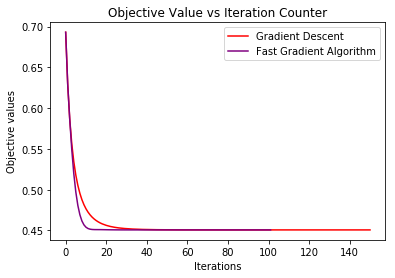

In [8]:
# set constants
epsilon = 0.0001
lamb = 0.1

# calculate initial step size
n = len(X)
eq = (1/n * X.T.dot(X))
eigVals = eigh(eq)[0]
stepSize = 1 / (max(eigVals) + lamb)

# run algorithms
gdBeta, gdObjs = graddescent(X, y, stepSize = stepSize, targetAccuracy = epsilon, lamb = lamb)
fgBeta, fgObjs = fastgradalgo(X, y, stepSize = stepSize, targetAccuracy = epsilon, lamb = lamb)

# plot 
plt.plot(gdObjs, color = "red")
plt.plot(fgObjs, color = "purple")
plt.ylabel("Objective values")
plt.xlabel("Iterations")
plt.title("Objective Value vs Iteration Counter")
plt.legend(["Gradient Descent", "Fast Gradient Algorithm"])
plt.show()

**Denote by $\beta_T$ the final iterate of your fast gradient algorithm. Compare $\beta_T$ to the $\beta^*$ found by _scikit-learn_. Compare the objective value for $\beta_T$ to the one for $\beta^*$. What do you observe?**

In [9]:
betaT = fgBeta[-1]

model = LogisticRegression(penalty='l2', dual=False, C=1/lamb, tol=epsilon, fit_intercept=False, solver='saga')
model = model.fit(X, y)
betaStar = model.coef_

betaT
betaStar = betaStar[0].reshape(57,1)
betaDiff = betaT - betaStar

df = pd.DataFrame({"Beta_T":betaT.tolist(), "Beta*":betaStar.tolist(), "Difference Beta_T - Beta*":betaDiff.tolist()})
display(df)

,Beta_T,Beta*,Difference Beta_T - Beta*
0,[0.0296838835539165],[-0.04478328605071632],[0.07446716960463282]
1,[-0.022269283777930245],[-0.11350791237301494],[0.09123862859508469]
2,[0.0866739372015923],[0.09723828140899204],[-0.01056434420739974]
3,[0.058816618172809795],[0.4912937530941173],[-0.4324771349213075]
4,[0.17540317127471478],[0.43770870232489145],[-0.2623055310501767]
5,[0.12131126324429015],[0.13895824279105973],[-0.01764697954676958]
6,[0.2946632634166697],[1.4440995060485229],[-1.1494362426318532]
7,[0.13224707928458088],[0.2246622972089024],[-0.09241521792432153]
8,[0.12260681873269294],[0.17431265529502485],[-0.05170583656233191]
9,[0.05079485625763609],[0.03205527947668576],[0.018739576780950333]


In [10]:
objBetaT = fgObjs[-1]
objBetaStar = computeobj(X, y, betaStar.reshape(57, 1), lamb = 0.1)

df = pd.DataFrame([[objBetaStar], [objBetaT]], index = ["Beta*", "Beta_T"], columns=["Objective"])
display(df)

,Objective
Beta*,1.724822
Beta_T,0.450686


Again, the value from our model may be an overfitting as we see a lower value for the objective calculated by our fast gradient algorithm than the one by skikit learn Logistic Regression function. There may be parameters that are 

**Run cross-validation on the training set of the Spam dataset using _scikit-learn_ to find the optimal value of λ. Run _graddescent_ and _fastgradalgo_ to optimize the objective with that value of λ. Plot the curve of the objective values $F(\beta_t)$ for both algorithms versus the iteration counter t. Plot the misclassification error on the training set for both algorithms versus the iteration counter t. Plot the misclassification error on the test set for both algorithms versus the iteration counter t. What do you observe?**

In [11]:
#cross validation to find best lambda
param_grid = {'C': [0.001, 0.05, 0.01, .5, 0.1, .5, 1, 5, 10, 50, 100, 500, 1000] }
clf = GridSearchCV(model, param_grid)
newLamb = clf.fit(X, y).best_estimator_.get_params()['C']

0.05

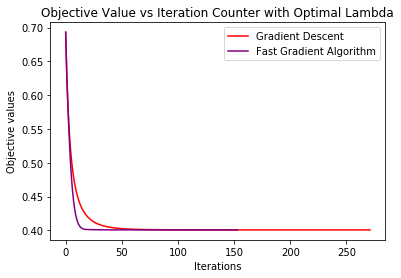

In [12]:
# run algorithms
newGdBeta, newGdObjs = graddescent(X, y, stepSize = stepSize, targetAccuracy = epsilon, lamb = newLamb)
newFgBeta, newFgObjs = fastgradalgo(X, y, stepSize = stepSize, targetAccuracy = epsilon, lamb = newLamb)

# plot curves
plt.plot(newGdObjs, color = "red")
plt.plot(newFgObjs, color = "purple")
plt.ylabel("Objective values")
plt.xlabel("Iterations")
plt.title("Objective Value vs Iteration Counter with Optimal Lambda")
plt.legend(["Gradient Descent", "Fast Gradient Algorithm"])
plt.show()

In [13]:
def calcMisclassificationError(X, y, betas):
    """
    Calculates the misclassification error for a binary response variable
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes, binary
        - betas: coefficients that correspond to X values
    Outputs:
        - misclassifications: ratio of incorrect values / total values for all betas
    """
    misclassifications = np.zeros((betas.shape[0], 1))
    for b in range(betas.shape[0]):
        betaVals = betas[b]
        incorrect = 0
        for i in range(X.shape[0]):
            Xi = X[i]
            prediction = 0
            for j in range(X.shape[1]):
                prediction += (Xi[j] * betaVals[j])
            if(prediction > 0):
                prediction = 1
            else:
                prediction = -1
            if(prediction != y[i]):
                incorrect +=1
        misclassifications[b,:] = (incorrect / X.shape[0])
    return misclassifications

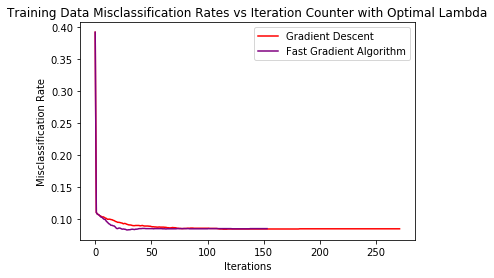

In [15]:
# plot misclassification error on training set
gdTrainMisclassification = calcMisclassificationError(X, y, newGdBeta)
fgTrainMisclassification = calcMisclassificationError(X, y, newFgBeta)
        
# plot curves
plt.plot(gdTrainMisclassification, color = "red")
plt.plot(fgTrainMisclassification, color = "purple")
plt.ylabel("Misclassification Rate")
plt.xlabel("Iterations")
plt.title("Training Data Misclassification Rates vs Iteration Counter with Optimal Lambda")
plt.legend(["Gradient Descent", "Fast Gradient Algorithm"])
plt.show()

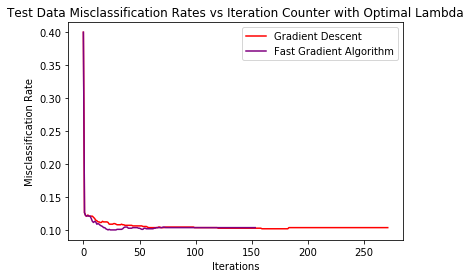

In [16]:
# plot misclassification error on test set
gdTestMisclassification = calcMisclassificationError(X_test, y_test, newGdBeta)
fgTestMisclassification = calcMisclassificationError(X_test, y_test, newFgBeta)
        
# plot curves
plt.plot(gdTestMisclassification, color = "red")
plt.plot(fgTestMisclassification, color = "purple")
plt.ylabel("Misclassification Rate")
plt.xlabel("Iterations")
plt.title("Test Data Misclassification Rates vs Iteration Counter with Optimal Lambda")
plt.legend(["Gradient Descent", "Fast Gradient Algorithm"])
plt.show()

TALK ABOUT THIS!!!

Lambda (λ) controls the trade-off between allowing the model to increase it's complexity as much as it wants with trying to keep it simple. For example, if λ is very low or 0, the model will have enough power to increase it's complexity (overfit) by assigning big values to the weights for each parameter. If, in the other hand, we increase the value of λ, the model will tend to underfit, as the model will become too simple. (https://www.kaggle.com/joparga3/2-tuning-parameters-for-logistic-regression)

### Exercise 2

**Suppose we estimate the regression coefficients in a logistic regression model by minimizing $$F(\beta) := \frac{1}{n} \sum_{i=1}^{n} \log(1 + \exp(-y_ix_i^T\beta)) + \lambda ||\beta||_2^2$$ for a particular value of $\lambda$. For parts (a) through (e), indicate which of (i) through (v) is correct. Justify your answer.**

**(a)  As we increase $\lambda$ from 0, the misclassification error on the test set will:  
(i) Increase initially, and then eventually start decreasing in an inverted U shape.  
(ii) Decrease initially, and then eventually start increasing in a U shape.  
(iii) Steadily increase.  
(iv) Steadily decrease.  
(v) Remain constant**

As lambda increases from zero we would expect case ii, where the misclassification error on the test set will decrease initially and then start increasing in a U shape.

ii. look at equation on slide 8, there is an ideal lambda value for which the model is general enough and then it gets too general and the misclassification error gets higher  

bias variaince tradeoff and switches at local min

**(b)  Repeat (a) for the misclassification error on the training set.**

As lambda increases from zero we would expect case i, where the misclassification error on the training set will increase initially and then eventually start decreasing in an inverted U shape.

i. this is penalizing betas and if they are already optimized this will then:  

Betas are already fit for this data so as your increase lambda the error will increase since worse fit for the training data exactly

### Exercise 3

**(a) The fitting and testing times on both the CPU and GPU versions. You can find these in the output.**

In [17]:
df = pd.DataFrame({"GPU": (9.029633, 44.250862), "CPU": (1.102070, 982.011376)})
df.rename(index={0:"Fitting Time", 1:"Testing Time"}, inplace = True)
display(df)

,GPU,CPU
Fitting Time,9.029633,1.102070
Testing Time,44.250862,982.011376


**The url from the previous step (Check to make sure you successfully made it public!)**

My output file can be found here: https://s3.amazonaws.com/stat558-twilson/data558_astronomyoutput.txt

**A statement of any problems you encountered during this exercise and how you overcame them (or if you didn’t).**

I got stuck in a few places, mainly with the unfamiliar Ubuntu file system and the AWS commands but was able to resolve them by searching Stack Overflow and similar sources for guidance.

**How long it took you to complete this exercise (for our reference–we’re not grading you on how long it took).**

It took me around 3 hours, but that includes time to familiarize myself with Ubuntu shell, AWS Console, etc.

It took me another 3 hours to get AWS to run for Exercise 4 to get the feature files generated as the steps were a bit different and I was unfamiliar with the preset up environments on the Machine Learning AMI.

### Exercise 4

**Download the data for the Kaggle competition. Run the script `extract_features.py` to extract features from the images. This script was written in Python 3 and depends on the library PyTorch.**

**Pick two classes of your choice from the dataset. Train an $l_2^2$-regularized logistic regression classifier on the training set using your own fast gradient algorithm with $\lambda = 1$.Be sure to use the features you generated above rather than the raw image features. Plot, with different colors, the _misclassification error_ on the training set and on the validation set vs iterations**

In [33]:
data_dir = "../Kaggle/data_competition1_files"

x_train_unfiltered = np.load(os.path.join(data_dir, 'train_features.npy'))
y_train_unfiltered = np.load(os.path.join(data_dir, 'train_labels.npy'))
x_test_unfiltered = np.load(os.path.join(data_dir, 'val_features.npy'))
y_test_unfiltered = np.load(os.path.join(data_dir, 'val_labels.npy'))

kaggleTest = np.load(os.path.join(data_dir, 'test_features.npy'))

# filter testing data to two classes: 4, 7
x_train = np.zeros((1000, x_train_unfiltered.shape[1]))
y_train = np.zeros((1000, 1))
index = 0
for i in range(y_train_unfiltered.shape[0]):
    if(y_train_unfiltered[i] == 4 or y_train_unfiltered[i] == 7):
        x_train[index, :] = x_train_unfiltered[i].T
        y_train[index, :] = y_train_unfiltered[i]
        index += 1

# filter testing data to two classes: 4, 7
x_test = np.zeros((200, x_test_unfiltered.shape[1]))
y_test = np.zeros((200, 1))
index = 0
for i in range(y_test_unfiltered.shape[0]):
    if(y_test_unfiltered[i] == 4 or y_test_unfiltered[i] == 7):
        x_test[index, :] = x_test_unfiltered[i].T
        y_test[index, :] = y_test_unfiltered[i]
        index += 1

# check dimensions
print("Number of images in x_train:", x_train.shape[0])
print("Dimension of features:", x_train.shape[1])

# standardize x values
xScaler = preprocessing.StandardScaler()
X_train = xScaler.fit_transform(x_train)
X_test = xScaler.transform(x_test)

Number of images in x_train: 1000
Dimension of features: 4096


In [34]:
def calcKaggleMisclassificationError(X, y, betas):
    """
    Calculates the misclassification error for a 0-9 response variable
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes, 0-9
        - betas: coefficients that correspond to X values
    Outputs:
        - misclassifications: ratio of incorrect values / total values for all betas
    """
    misclassifications = np.zeros((betas.shape[0], 1))
    for b in range(betas.shape[0]):
        betaVals = betas[b]
        incorrect = 0
        for i in range(X.shape[0]):
            Xi = X[i]
            prediction = 0
            for j in range(X.shape[1]):
                prediction += (Xi[j] * betaVals[j])
            prediction = math.floor(prediction)
            if(prediction != y[i]):
                incorrect +=1
        misclassifications[b,:] = (incorrect / X.shape[0])
    return misclassifications

In [ ]:
lamb = 1.0

trainBeta, trainObjs = fastgradalgo(x_train, y_train, stepSize = stepSize, targetAccuracy = epsilon, lamb = lamb)
valBeta, valObjs = fastgradalgo(x_test, y_test, stepSize = stepSize, targetAccuracy = epsilon, lamb = lamb)

In [ ]:
# plot misclassification error on training set
trainMisclassification = calcKaggleMisclassificationError(x_train, y_train, trainBeta)
valMisclassification = calcKaggleMisclassificationError(x_test, y_test, valBeta)
        
# plot curves
plt.plot(gdTrainMisclassification, color = "red")
plt.plot(fgTrainMisclassification, color = "purple")
plt.ylabel("Misclassification Rate")
plt.xlabel("Iterations")
plt.title("Training Data Misclassification Rates vs Iteration Counter with Optimal Lambda")
plt.legend(["Gradient Descent", "Fast Gradient Algorithm"])
plt.show()

**Find the value of the regularization parameter $\lambda$ using cross-validation; you may use scikit-learn’s built-in functions for this purpose. Train an $l_2^2$-regularized logistic regression classifier on the training set using your own fast gradient algorithm with that value of $\lambda$ found by cross-validation. Plot, with different colors, the _misclassification error_ on the training set and on the validation set vs iterations.**

In [ ]:
model = LogisticRegression(penalty='l2', dual=False, C=1/lamb, tol=epsilon, fit_intercept=False, solver='saga')
model = model.fit(x_train, y_train)

#cross validation to find best lambda
param_grid = {'C': [0.001, 0.05, 0.01, .5, 0.1, .5, 1, 5, 10, 50, 100, 500, 1000] }
clf = GridSearchCV(model, param_grid)
newLamb = clf.fit(x_train, y_train).best_estimator_.get_params()['C']

In [ ]:
newTrainBeta, newTrainObjs = fastgradalgo(x_train, y_train, stepSize = stepSize, targetAccuracy = epsilon, lamb = newLamb)
newValBeta, newValObjs = fastgradalgo(x_test, y_test, stepSize = stepSize, targetAccuracy = epsilon, lamb = newLamb)

In [ ]:
# plot misclassification error on training set
newTrainMisclassification = calcKaggleMisclassificationError(x_train, y_train, newTrainBeta)
newValMisclassification = calcKaggleMisclassificationError(x_test, y_test, newValBeta)
        
# plot curves
plt.plot(gdTrainMisclassification, color = "red")
plt.plot(fgTrainMisclassification, color = "purple")
plt.ylabel("Misclassification Rate")
plt.xlabel("Iterations")
plt.title("Training Data Misclassification Rates vs Iteration Counter with Optimal Lambda")
plt.legend(["Gradient Descent", "Fast Gradient Algorithm"])
plt.show()

### Exercise 5

**It is well-known that ridge regression tends to give similar coefficient values to correlated variables, whereas the lasso may give quite different coefficient values to correlated variables. We will now explore this property in a very simple setting.   
Suppose that $n=2, p =2, x_{11}=x_{12}=x_{21}=x_{22}$. Furthermore, suppose that $y_1+y_2=0$ and $x_{11}+x_{21}=0$ and $x_{12}+x_{22}=0$, so that the estimate for the intercept in a least squares, ridge regression, or lasso model is zero: $\hat{\beta_0}=0$**

**(a) Write out the ridge regression optimization problem in this setting.**

**(b) Argue that in this setting, the ridge coefficient estimates satisfy $\beta_1 = \beta_2$**